In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import gym
from gym.envs.toy_text.utils import categorical_sample
import random
import numpy as np

# Section 0: Auxilary Functions

In [2]:
def success_rate(environment, qtable, total_trials=1000):
    num_success = 0
    for _ in range(total_trials):
        state, prob = environment.reset()
        terminated = False
        
        while not terminated:
            if np.max(qtable[state]) > 0:
                action = np.argmax(qtable[state])
            else:
                action = environment.action_space.sample()
            
            new_state, reward, terminated, *info = environment.step(action)
            state = new_state
            num_success +=reward # reward=1 at terminal state
    return num_success/total_trials * 100

# Section 1: Q-Learning

In [3]:
def q_learn(environment, episodes, gamma, store_data_for_graphing=0):
    """alpha is 1/(1+k), k increments by one when goal
    reached i.e.,"roll on success".
    epsilon Q learning with epsion probability we explore
    epsilon decay is 1/epsiodes

    Args:
        environment (_type_): _description_
        episodes (_type_): _description_
        gamma (_type_): _description_
    """
    alpha = 0.5
    epsilon = 1.0
    epsilon_decay = 1/episodes
    
    qtable = np.zeros((environment.observation_space.n, 
                       environment.action_space.n))
    episode_scores = []
    roll_on_success = 1
    for episode_num in range(episodes):
        print(f"\rQ-learn Loop: {episode_num}/{episodes}", end='', flush=True)
        
        state, prob = environment.reset()
        terminated = False
        alpha = 1 / (roll_on_success + 1)
        while not terminated:
            rnd = np.random.random()
            if rnd < epsilon:
                action = environment.action_space.sample()
            else:
                action = np.argmax(qtable[state])
            
            new_state, reward, terminated, *info = environment.step(action)
            qtable[state, action] = (qtable[state, action] +
                                    alpha * (reward 
                                            + gamma *np.max(qtable[new_state])
                                            - qtable[state, action]))
            state = new_state
                
        row, col = divmod(new_state, environment.ncol)
        state_type = environment.desc[row][col].decode()
        if state_type == 'G':
            # print(state_type)
            roll_on_success += 1
        
        epsilon = max(epsilon-epsilon_decay, 0)
        if store_data_for_graphing ==1:
            episode_scores.append(success_rate(environment, qtable))
    
    return qtable, episode_scores

### Section 1.1: test Q learning

In [4]:
environment = gym.make("FrozenLake-v1", render_mode="ansi", is_slippery=True)
environment.reset()

episodes = 5_000
gamma = 0.99

qtable, episodes_scores = q_learn(environment, episodes, gamma, store_data_for_graphing=1)


Q-learn Loop: 3/5000

c:\Users\CPS_LabPC_03\anaconda3.10\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Q-learn Loop: 4999/5000

In [5]:
print(success_rate(environment, qtable))

77.7


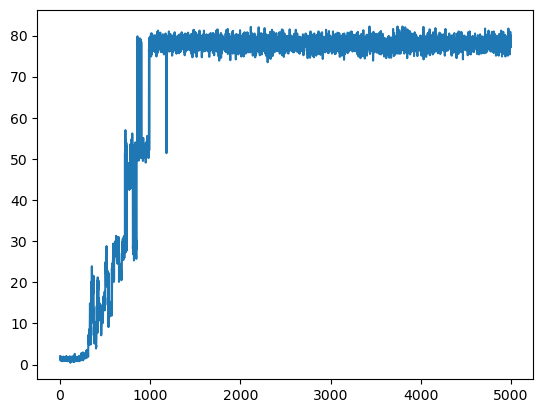

In [6]:
plt.plot(episodes_scores)
plt.show()

# Section 2: Synchronous Speedy Q learning

In [7]:
def synchronous_speedy_q_learning(environment, episodes, gamma, 
                                  store_data_for_graphing=0):
    """alpha is 1/(episode number + 1)
    sycnronous
    
    Args:
        environment (_type_): _description_
        episodes (_type_): _description_
        gamma (_type_): _description_
        store_data_for_graphing (int, optional): _description_. Defaults to 0.
    """
    qtable_prev = np.zeros((environment.observation_space.n,
                            environment.action_space.n))
    qtable_curr = np.zeros((environment.observation_space.n,
                            environment.action_space.n))
    T = episodes
    episode_scores = []
    # Create a NumPy random number generator
    np_random = np.random.RandomState()

    for k in range(T):
        print(f"\rIteration: {k+1}/{T}", end='', flush=True)
        TkQk_mins_1 = np.zeros_like(qtable_curr)
        TkQk = np.zeros_like(qtable_curr)
        for state in range(environment.observation_space.n):
            for action in range(environment.action_space.n):
                # select state randomly
                transitions = environment.P[state][action]
                # print(transitions)
                index = categorical_sample([t[0] for t in transitions], 
                                           np_random)

                prob, new_state, reward, terminated = transitions[index]
                
                TkQk_mins_1[state, action] = (reward + gamma * np.max(qtable_prev[new_state]))
                TkQk[state, action] = (reward + gamma * np.max(qtable_curr[new_state]))
        alpha_k = 1/(k+1)
        qtable_prev = np.copy(qtable_curr)
        qtable_curr += (alpha_k * (TkQk_mins_1 - qtable_curr) 
                        + (1-alpha_k) * (TkQk - TkQk_mins_1))
        if store_data_for_graphing ==1:
            episode_scores.append(success_rate(environment, qtable_curr))
    return qtable_curr, episode_scores

### Section 2.1: test synchronous speedy Q learning

In [8]:
sync_speed_environment = gym.make("FrozenLake-v1", render_mode="ansi", is_slippery=True)
sync_speed_environment.reset()

sync_speed_episodes = 5_000
sync_speed_gamma = 0.99

sync_speed_qtable, sync_speed_episodes_scores = synchronous_speedy_q_learning(sync_speed_environment, 
                                                        sync_speed_episodes, 
                                                        sync_speed_gamma, 
                                                        store_data_for_graphing=1)


Iteration: 149/5000

KeyboardInterrupt: 

In [ ]:
plt.plot(episodes_scores, label='Q-learning')
plt.plot(sync_speed_episodes_scores, label='synch speedy Q learn')
plt.xlabel('episodes')
plt.ylabel('average success rate')
plt.legend()
plt.show()

# Section 3: Asynchronous Speedy Q learning

In [ ]:
def asynchronous_speedy_q_learning(environment, episodes, gamma, 
                                  store_data_for_graphing=0):
    """alpha is 1/(episode number + 1)
    sycnronous
    
    Args:
        environment (_type_): _description_
        episodes (_type_): _description_
        gamma (_type_): _description_
        store_data_for_graphing (int, optional): _description_. Defaults to 0.
    """
    qtable_prev = np.zeros((environment.observation_space.n,
                            environment.action_space.n))
    qtable_curr = np.zeros((environment.observation_space.n,
                            environment.action_space.n))
    T = episodes
    episode_scores = []
    # Create a NumPy random number generator
    np_random = np.random.RandomState()

    for k in range(T):
        print(f"\rIteration: {k+1}/{T}", end='', flush=True)
        TkQk_mins_1 = np.zeros_like(qtable_curr)
        TkQk = np.zeros_like(qtable_curr)
        alpha_k = 1/(k+1)
        for state in range(environment.observation_space.n):
            for action in range(environment.action_space.n):
                # select state randomly
                transitions = environment.P[state][action]
                # print(transitions)
                index = categorical_sample([t[0] for t in transitions], 
                                           np_random)

                prob, new_state, reward, terminated = transitions[index]
                
                TkQk_mins_1[state, action] = (reward + gamma * np.max(qtable_prev[new_state]))
                TkQk[state, action] = (reward + gamma * np.max(qtable_curr[new_state]))
                qtable_prev[state, action] = qtable_curr[state, action]
                qtable_curr[state, action] +=(alpha_k*(TkQk_mins_1[state, action] 
                                                       - qtable_curr[state, action])
                                              + (1-alpha_k) * (TkQk[state, action]
                                                               - TkQk_mins_1[state, action]))
                
        if store_data_for_graphing ==1:
            episode_scores.append(success_rate(environment, qtable_curr))
    return qtable_curr, episode_scores

### Section 3.1: test Asynchronous Speedy Q learning

In [ ]:
async_speed_environment = gym.make("FrozenLake-v1", render_mode="ansi", is_slippery=True)
async_speed_environment.reset()

async_speed_episodes = 5_000
async_speed_gamma = 0.99

async_speed_qtable, async_speed_episodes_scores = asynchronous_speedy_q_learning(async_speed_environment, 
                                                        async_speed_episodes, 
                                                        async_speed_gamma, 
                                                        store_data_for_graphing=1)


In [ ]:
plt.plot(episodes_scores, label='Q-learning')
plt.plot(sync_speed_episodes_scores, label='synch speedy Q learn')
plt.plot(async_speed_episodes_scores, label='synch speedy Q learn')
plt.xlabel('episodes')
plt.ylabel('average success rate')
plt.legend()
plt.show()